<a href="https://colab.research.google.com/github/aldyam/SentimentAnalysis_ProgramMBG/blob/main/MBG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Sastrawi

import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

print("Persiapan Selesai!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00
Persiapan Selesai!


In [2]:
file_name = 'program_makan_bergizi_gratis_10k_data.csv'

# Baca data
df = pd.read_csv(file_name)

# Tampilkan 5 data teratas untuk pengecekan
print(f"Total Data: {df.shape[0]} baris")
print("Contoh Data Mentah:")
print(df[['full_text']].head())

Total Data: 10524 baris
Contoh Data Mentah:
                                           full_text
0  @ARSIPAJA Ini program makan siang gratis bukan...
1  Anak sehat bangsa kuat! ️ Dukung program makan...
2  Tak ada anak yang boleh lapar! Bersama kita du...
3  Nutrisi cukup prestasi meningkat! Makan siang ...
4  Bersama wujudkan Indonesia bebas gizi buruk! M...


In [3]:
# --- Setup Sastrawi ---
# 1. Stopword Remover (Buang kata umum: yang, dan, di, dll)
factory_sw = StopWordRemoverFactory()
stopword = factory_sw.create_stop_word_remover()

# --- Fungsi Pembersihan ---
def clean_text_final(text):
    # a. Case Folding (Huruf kecil semua)
    text = str(text).lower()

    # b. Regex Cleaning (Hapus simbol aneh)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Hapus Mention (@username)
    text = re.sub(r'#\w+', '', text)           # Hapus Hashtag
    text = re.sub(r'http\S+', '', text)        # Hapus Link URL
    text = re.sub(r'[^a-z\s]', '', text)       # Hapus Angka & Tanda Baca (Emoji dll)
    text = re.sub(r'\s+', ' ', text).strip()   # Hapus Spasi Ganda

    # c. Stopword Removal (Sastrawi)
    text = stopword.remove(text)

    return text

print("Sedang membersihkan 10.000 data... (Mohon tunggu sebentar)")
df['text_clean'] = df['full_text'].apply(clean_text_final)
print("Pembersihan Selesai!")

Sedang membersihkan 10.000 data... (Mohon tunggu sebentar)
Pembersihan Selesai!


In [4]:
# 1. Download Kamus InSet (Indonesia Sentiment Lexicon)
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt

# 2. Load Kamus ke Python
with open('positive.txt', 'r') as f:
    positive_words = set(f.read().splitlines())
with open('negative.txt', 'r') as f:
    negative_words = set(f.read().splitlines())

# --- TUNING (PERBAIKAN MODEL) ---
# Daftar kata yang "DI-BLACKLIST" dari kamus (Kata netral yang sering dianggap sentimen)
kata_bias = {'gratis', 'makan', 'siang', 'program', 'susu', 'anak', 'bergizi', 'menu', 'nasi', 'telur'}

# Buang kata bias dari kamus positif/negatif
for kata in kata_bias:
    positive_words.discard(kata)
    negative_words.discard(kata)

print(f"Kamus siap! Kata-kata bias {kata_bias} sudah dibuang agar akurasi naik.")

Kamus siap! Kata-kata bias {'siang', 'anak', 'telur', 'nasi', 'gratis', 'bergizi', 'program', 'susu', 'makan', 'menu'} sudah dibuang agar akurasi naik.


In [5]:
# Fungsi Hitung Skor
def get_sentiment_score(text):
    score = 0
    words = text.split()
    for word in words:
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1
    return score

# Fungsi Tentukan Label
def get_sentiment_label(score):
    if score > 0:
        return 'Positif'
    elif score < 0:
        return 'Negatif'
    else:
        return 'Netral'

# Eksekusi
print("Sedang melakukan pelabelan otomatis...")
df['sentiment_score'] = df['text_clean'].apply(get_sentiment_score)
df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)

# Tampilkan Hasil Statistik
print("\n--- HASIL AKHIR DISTRIBUSI SENTIMEN ---")
print(df['sentiment_label'].value_counts())
print("\n--- PERSENTASE ---")
print(df['sentiment_label'].value_counts(normalize=True) * 100)

Sedang melakukan pelabelan otomatis...

--- HASIL AKHIR DISTRIBUSI SENTIMEN ---
sentiment_label
Netral     5361
Positif    3355
Negatif    1808
Name: count, dtype: int64

--- PERSENTASE ---
sentiment_label
Netral     50.940707
Positif    31.879513
Negatif    17.179780
Name: proportion, dtype: float64


=== TOPIK KELUHAN NETIZEN (SENTIMEN NEGATIF) ===


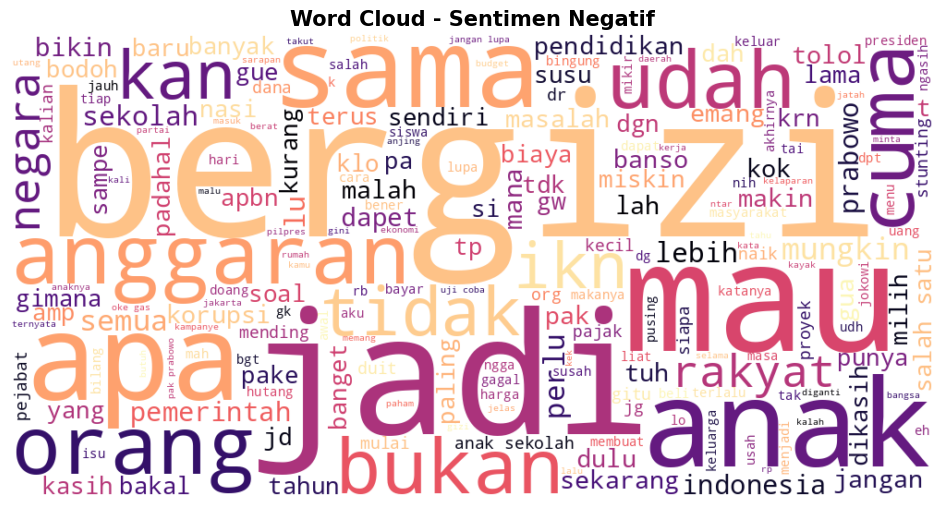

=== TOPIK DUKUNGAN NETIZEN (SENTIMEN POSITIF) ===


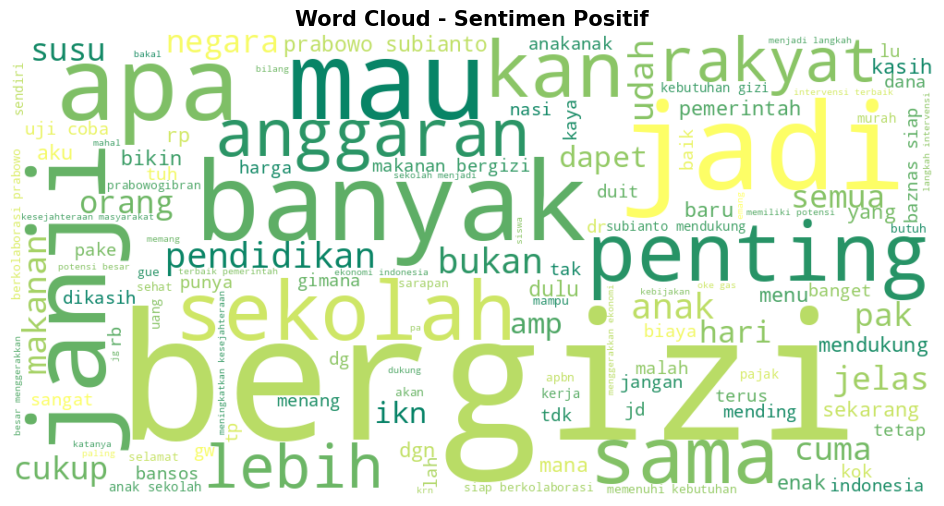

In [6]:
# Daftar kata yang DIHILANGKAN DARI GAMBAR (Stopwords Visual)
# Agar yang muncul cuma kata sifat/keluhan intinya saja
stopwords_visual = {'makan', 'siang', 'gratis', 'program', 'yg', 'dan', 'di', 'ke',
                    'ini', 'itu', 'buat', 'tapi', 'kalau', 'ga', 'gak', 'bisa', 'ada',
                    'nya', 'sih', 'tau', 'aja', 'utk', 'sdh', 'kalo', 'biar'}

def plot_final_wordcloud(text_data, title, color_theme):
    all_text = ' '.join(text_data)
    wordcloud = WordCloud(width=1000, height=500,
                          background_color='white',
                          colormap=color_theme,
                          stopwords=stopwords_visual, # Filter aktif
                          min_font_size=10).generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.show()

# Tampilkan Word Cloud NEGATIF (Untuk Analisis Masalah)
print("=== TOPIK KELUHAN NETIZEN (SENTIMEN NEGATIF) ===")
plot_final_wordcloud(df[df['sentiment_label'] == 'Negatif']['text_clean'],
                     "Word Cloud - Sentimen Negatif", 'magma')

# Tampilkan Word Cloud POSITIF (Untuk Analisis Dukungan)
print("=== TOPIK DUKUNGAN NETIZEN (SENTIMEN POSITIF) ===")
plot_final_wordcloud(df[df['sentiment_label'] == 'Positif']['text_clean'],
                     "Word Cloud - Sentimen Positif", 'summer')

In [7]:
# Simpan ke CSV
nama_file_hasil = 'Laporan_Analisis_Sentimen_Final.csv'
df.to_csv(nama_file_hasil, index=False)

print(f"SUKSES! File '{nama_file_hasil}' sudah tersimpan.")
print("Silakan cek menu Files di sebelah kiri, klik titik tiga pada file tersebut -> Download.")

SUKSES! File 'Laporan_Analisis_Sentimen_Final.csv' sudah tersimpan.
Silakan cek menu Files di sebelah kiri, klik titik tiga pada file tersebut -> Download.


/tmp/ipython-input-1277498486.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=counts.values, palette=colors)


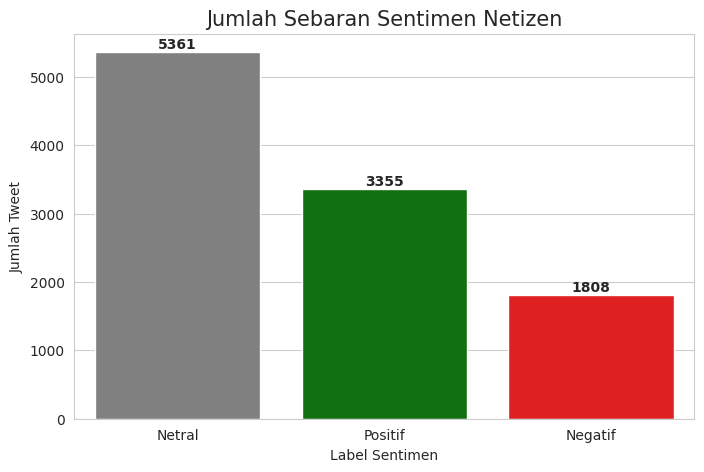

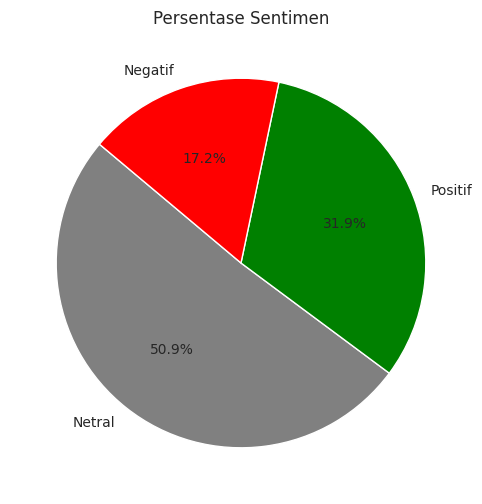

In [8]:
import seaborn as sns

# Atur gaya gambar
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Buat Data untuk Plot
counts = df['sentiment_label'].value_counts()
labels = counts.index
colors = {'Positif': 'green', 'Netral': 'gray', 'Negatif': 'red'}

# 1. Bikin Bar Chart
ax = sns.barplot(x=labels, y=counts.values, palette=colors)

# Tambahkan angka di atas batang biar jelas
for i, v in enumerate(counts.values):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.title('Jumlah Sebaran Sentimen Netizen', fontsize=15)
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Tweet')
plt.show()

# 2. Bikin Pie Chart (Opsional, buat lihat persen)
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=[colors[l] for l in labels], startangle=140)
plt.title('Persentase Sentimen')
plt.show()

[START] Memulai Machine Learning...
Model Machine Learning selesai dilatih!

📊 Akurasi Machine Learning: 67.46%

--- Detail Laporan Klasifikasi ---
              precision    recall  f1-score   support

     Negatif       0.88      0.10      0.18       341
      Netral       0.63      0.93      0.75      1076
     Positif       0.80      0.55      0.65       688

    accuracy                           0.67      2105
   macro avg       0.77      0.53      0.53      2105
weighted avg       0.73      0.67      0.63      2105



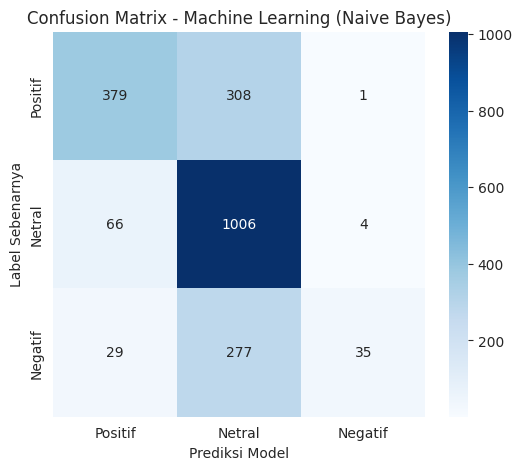

In [14]:
# BAGIAN 1: MACHINE LEARNING (Naive Bayes)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("[START] Memulai Machine Learning...")

# 1. Siapkan Data
X = df['text_clean'].astype(str)
y = df['sentiment_label']

# 2. Split Data (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Ubah Kata jadi Angka (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 4. Latih Model Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
print("Model Machine Learning selesai dilatih!")

# 5. Evaluasi & Prediksi
y_pred_nb = model_nb.predict(X_test_vec)
acc_ml = accuracy_score(y_test, y_pred_nb)

print(f"\n📊 Akurasi Machine Learning: {acc_ml*100:.2f}%")
print("\n--- Detail Laporan Klasifikasi ---")
print(classification_report(y_test, y_pred_nb))

# 6. Gambar Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_nb, labels=['Positif', 'Netral', 'Negatif'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positif', 'Netral', 'Negatif'],
            yticklabels=['Positif', 'Netral', 'Negatif'])
plt.title('Confusion Matrix - Machine Learning (Naive Bayes)')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Prediksi Model')
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\]'
<>:26: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-2528644801.py:26: SyntaxWarning: invalid escape sequence '\]'
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)


[START] Memulai Deep Learning (LSTM)... Mohon bersabar...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.5364 - loss: 0.9476 - val_accuracy: 0.6694 - val_loss: 0.7584
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.7412 - loss: 0.6401 - val_accuracy: 0.7924 - val_loss: 0.5330
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.8759 - loss: 0.3306 - val_accuracy: 0.8171 - val_loss: 0.4806
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9352 - loss: 0.1947 - val_accuracy: 0.8276 - val_loss: 0.5407
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9495 - loss: 0.1455 - val_accuracy: 0.8105 - val_loss: 0.5469

 Selesai! Akurasi Deep Learning: 81.05%


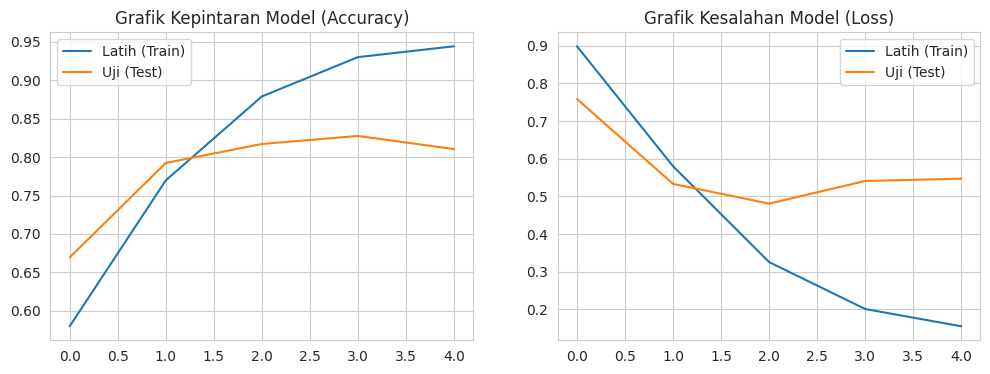

In [15]:
# BAGIAN 2: DEEP LEARNING (LSTM)

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
import matplotlib.pyplot as plt

print("[START] Memulai Deep Learning (LSTM)... Mohon bersabar...")

# 1. Encode Label (Ubah Positif/Netral/Negatif jadi 0, 1, 2)
# Deep Learning tidak bisa baca teks label, harus angka.
le = LabelEncoder()
y_enc = le.fit_transform(df['sentiment_label'])

# 2. Tokenization (Ubah kalimat jadi urutan angka)
MAX_NB_WORDS = 5000       # Kosakata maksimal
MAX_SEQUENCE_LENGTH = 50  # Panjang kalimat maksimal
EMBEDDING_DIM = 100       # Dimensi vektor

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text_clean'].astype(str))
X_lstm = tokenizer.texts_to_sequences(df['text_clean'].astype(str))
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)

# 3. Split Data Khusus LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm,
    pd.get_dummies(y_enc).values, # One-hot encoding untuk target
    test_size=0.2,
    random_state=42
)

# 4. Bangun Arsitektur Neural Network (Otak Buatan)
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax')) # Output 3 Kategori

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Mulai Training (Epochs = 5 kali putaran belajar)
history = model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64,
                    validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# 6. Evaluasi Hasil
acc_dl = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)[1]
print(f"\n Selesai! Akurasi Deep Learning: {acc_dl*100:.2f}%")

# 7. Grafik Proses Belajar
plt.figure(figsize=(12, 4))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Latih (Train)')
plt.plot(history.history['val_accuracy'], label='Uji (Test)')
plt.title('Grafik Kepintaran Model (Accuracy)')
plt.legend()

# Grafik Loss (Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Latih (Train)')
plt.plot(history.history['val_loss'], label='Uji (Test)')
plt.title('Grafik Kesalahan Model (Loss)')
plt.legend()

plt.show()